The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DATA_PATH is set to: \\10.34.1.59\big_gulp\nc4_rat_data\Maze_Rats
Using path: \\10.34.1.59\big_gulp\nc4_rat_data\Maze_Rats
Using path: \\10.34.1.59\big_gulp\nc4_rat_data\Maze_Rats
Looking in folder: \\10.34.1.59\big_gulp\nc4_rat_data\Maze_Rats\NC40008
Looking in folder: \\10.34.1.59\big_gulp\nc4_rat_data\Maze_Rats\NC40008\241202
['Chamber 5 selected', 'Current trial number: 0', "START OF TRIAL ['Triangle', 'No_Cue', 'Green']", 'ERROR', 'Right chamber selected and chamber number is 1', 'Chamber 5 selected', 'Current trial number: 1', "START OF TRIAL ['No_Cue', 'Triangle', 'Green']", 'ERROR', 'Left chamber selected and chamber number is 7', 'Chamber 5 selected', 'Current trial number: 2', "START OF TRIAL ['No_Cue', 'Triangle', 'Green']", 'SUCCESS', 'Right chamber selected and chamber number is 1', 'Chamber 5 selected', 'Current trial number: 3', "START OF TRIAL ['Triangle', 'No_Cue', 'Green']", 'SUCCE

C:\Users\afsoo\AppData\Local\Temp\ipykernel_11268\2947008227.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Trial Type'] = new_df.apply(determine_trial_type, axis=1)


DataFrame saved to \\10.34.1.59\big_gulp\nc4_rat_data\Maze_Rats\NC40008\241202\extracted_biases.csv
   Trial Type  Error_Count  Success_Count  Total_Repetitions
0           1            2              8                 10
1           2            0              5                  5
2           3            8             21                 29
3           4           12             18                 30
   Trial Type  Error_Count  Success_Count  Total_Repetitions
0           1            2              8                 10
1           2            0              5                  5
2           3            8             21                 29
3           4           12             18                 30
   Trial Type  Error_Count  Success_Count  Total_Repetitions
0           1            2              8                 10
1           2            0              5                  5
2           3            8             21                 29
3           4           12             18     

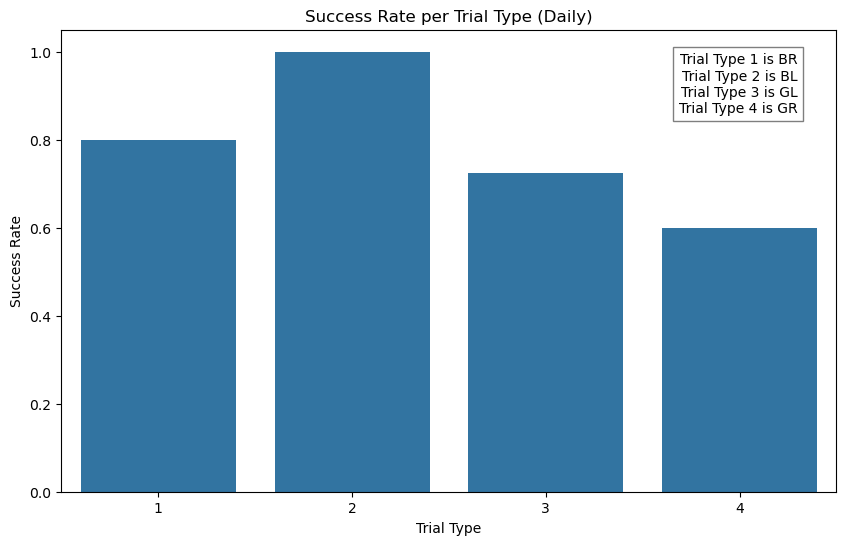

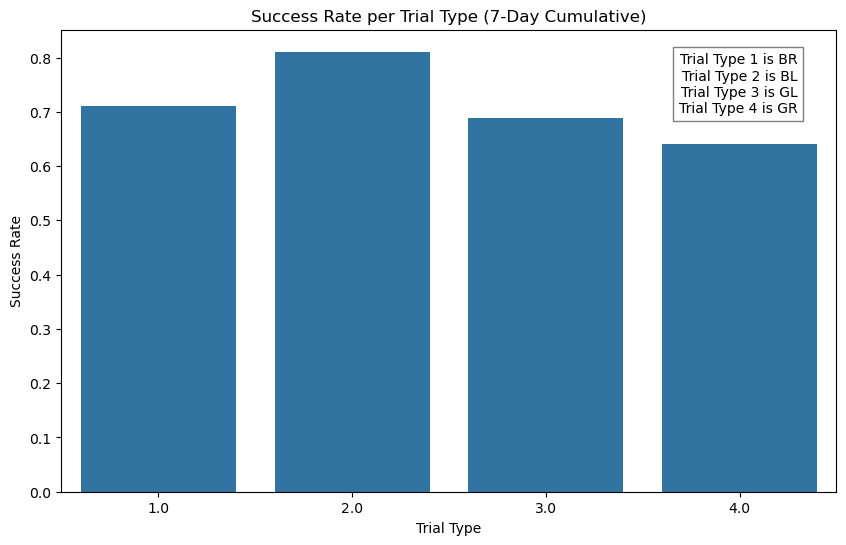

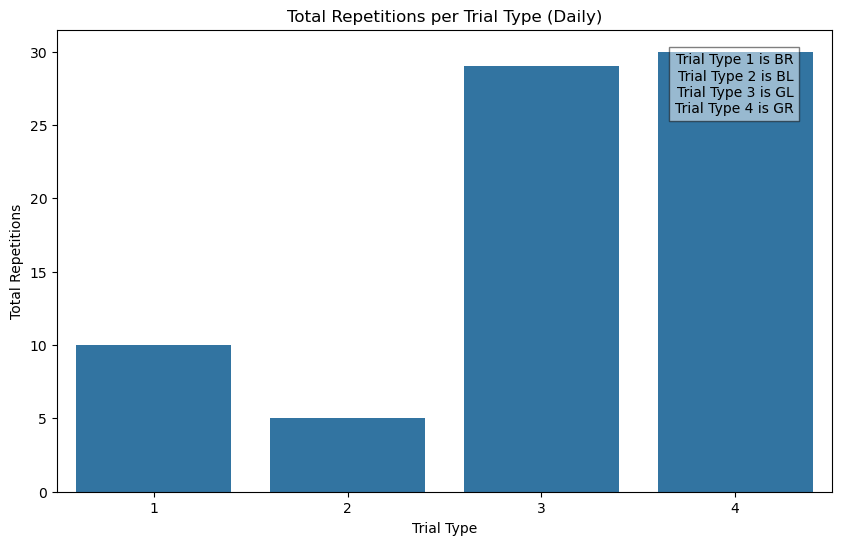

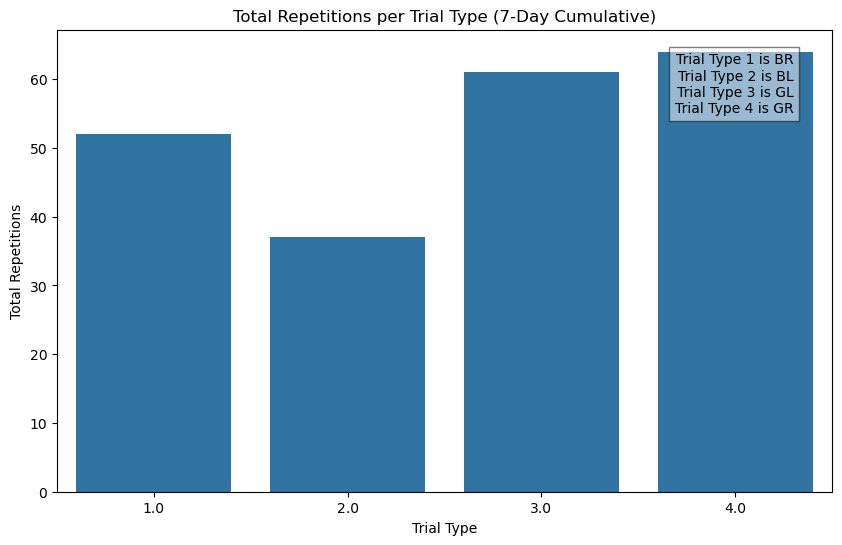

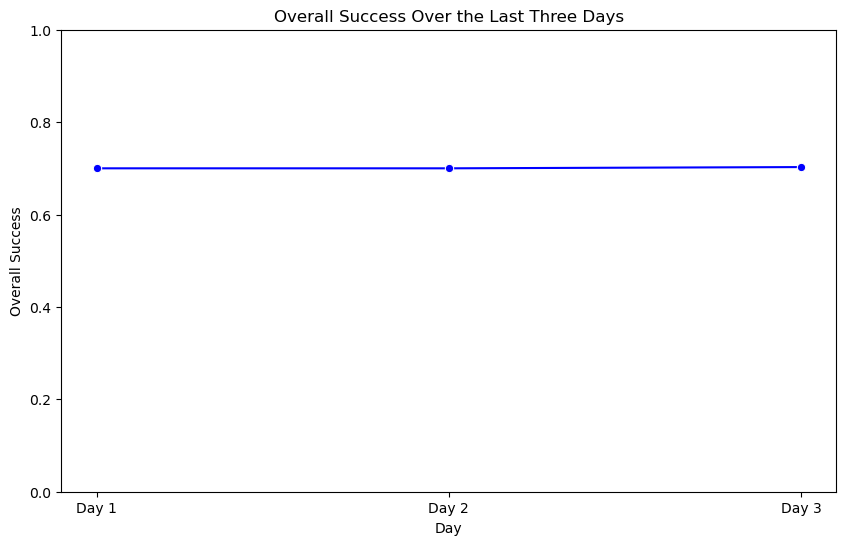

Chi-square Statistic: 0.07526815764452843
P-Value: 0.9946302967647612
No statistically significant difference found across trial types.


In [28]:
import bagpy
from bagpy import bagreader
import os
import pandas as pd
from dateutil.parser import parse as parsedate
import matplotlib.pyplot as plt
from rosbags.highlevel import AnyReader as RosBagReader
from pathlib import Path
import logging
from dotenv import dotenv_values
from dotenv import load_dotenv
import ast 
import math
from functions import *
import seaborn as sns
from scipy.stats import chi2_contingency, chi2

%load_ext autoreload
%autoreload 2

config = dotenv_values()
data_path = os.path.normpath(config['DATA_PATH'])
os.environ['DATA_PATH'] = data_path
print(f"DATA_PATH is set to: {os.environ['DATA_PATH']}")

rat_number = 8
date = '241202'

messages, bag_file = determine_trial_info(rat_number, date)

extracted_biases_file_path = os.path.join(os.path.dirname(bag_file), 'extracted_biases.csv')

#check whether the files aleady exist. If they exist read them if not create them.
if os.path.exists(extracted_biases_file_path):
    #read the extracted bias csv file that contains trial information
    extracted_biases = pd.read_csv(extracted_biases_file_path)
    #read the trial type summary csv file
    csv_trial_type_summary = os.path.join(os.path.dirname(bag_file), 'trial_type_summary.csv')
    trial_type_summary = pd.read_csv(csv_trial_type_summary)
    print('The dataframes have been created previously')
else:
    filtered_masseages = filter_start_of_trial_messages(messages)

    final_messages = remove_specific_message(filtered_masseages)
    
    #del final_messages[131:133]
    #del final_messages[-3:]
    #final_messages.insert(0,'Chamber 5 selected')
    print(final_messages)
    df = create_dataframe_from_messages(final_messages)

    trial_info = df['Trial'].apply(lambda x: pd.Series(extract_trial_info(x)))

    if trial_info.shape[1] == 3:
        df[['Left Cue', 'Right Cue', 'Floor Cue']] = df['Trial'].apply(lambda x: pd.Series(extract_trial_info(x)))
        df['Start Chamber Number'] = df['Start Chamber'].str.extract(r'Chamber (\d+)')
        new_df = df[['Number', 'Start Chamber Number', 'Left Cue', 'Right Cue', 'Floor Cue', 'Result', 'Choice']]
        new_df['Trial Type'] = new_df.apply(determine_trial_type, axis=1)
    elif trial_info.shape[1] == 4:
        df[['Left Cue', 'Right Cue', 'Floor Cue', 'Training Mode']] = df['Trial'].apply(lambda x: pd.Series(extract_trial_info(x)))
        df['Start Chamber Number'] = df['Start Chamber'].str.extract(r'Chamber (\d+)')
        new_df = df[['Number', 'Start Chamber Number', 'Left Cue', 'Right Cue', 'Floor Cue', 'Training Mode', 'Result', 'Choice']]
        new_df['Trial Type'] = new_df.apply(determine_trial_type, axis=1)
        new_df = remove_rows_with_value(new_df, 'Training Mode', 'forced_choice')

    new_df.to_csv(extracted_biases_file_path, index=False)

    print(f"DataFrame saved to {extracted_biases_file_path}")

    # Group by 'Trial Types' and 'Results' and count occurrences
    grouped_df = new_df.groupby(['Trial Type', 'Result']).size().unstack(fill_value=0)

    # Rename columns for clarity
    grouped_df.columns = ['Error_Count', 'Success_Count']

    # Calculate total repetitions of each trial type
    grouped_df['Total_Repetitions'] = grouped_df.sum(axis=1)

    # Reset index to make 'Trial Types' a column again
    grouped_df = grouped_df.reset_index()

     #Create a DataFrame with all 4 trial types and zeros for counts
    all_trial_types = pd.DataFrame({
        'Trial Type': range(1, 5)
    })
    print(grouped_df)
    # Merge the all_trial_types DataFrame with grouped_df
    # Use a left join to ensure all trial types are included
    final_df = pd.merge(all_trial_types, grouped_df, on='Trial Type', how='left')
    print(final_df)
    # Fill NaN values resulting from the merge with 0
    final_df = final_df.fillna(0)
    print(final_df)

    # Ensure all counts are integers
    final_df['Error_Count'] = final_df['Error_Count'].astype(int)
    final_df['Success_Count'] = final_df['Success_Count'].astype(int)
    final_df['Total_Repetitions'] = final_df['Total_Repetitions'].astype(int)

    # Save the aggregated data to a new CSV file
    output_csv_path = os.path.join(os.path.dirname(bag_file), 'trial_type_summary.csv')
    grouped_df.to_csv(output_csv_path, index=False)

    print(f"Summary saved to {output_csv_path}")

past_three_days_file_path = os.path.join(os.path.dirname(bag_file), 'Past_three_days_biases.csv')
overall_success_path = os.path.join(os.path.dirname(bag_file), 'Overall_Success.csv')
#check whether the analysis csv files of the past three days aleady exists. If it exists read it if not create it.
if os.path.exists(past_three_days_file_path):
    #read the extracted bias csv file that contains trial information
    past_three_days_biases = pd.read_csv(past_three_days_file_path)
    overall_success = pd.read_csv(overall_success_path)
    print('The dataframes have been created previously')
else:
    combine_csv_files(rat_number, date)
    past_three_days_biases = pd.read_csv(past_three_days_file_path)
    overall_success = pd.read_csv(overall_success_path)

save_plots_dir = os.path.join(os.path.dirname(bag_file), 'plots')

#check whether the plots have been created before. If not, create them.
if os.path.exists(save_plots_dir):
    print('The plots have been created previously')
else:
    csv_trial_type_summary = os.path.join(os.path.dirname(bag_file), 'trial_type_summary.csv')
    trial_type_summary = pd.read_csv(csv_trial_type_summary)
    trial_type_summary['Success_Rate'] = trial_type_summary['Success_Count'] / trial_type_summary['Total_Repetitions']
    
    # Create the 'plots' directory if it doesn't exist
    os.makedirs(save_plots_dir, exist_ok=True)

    text = "Trial Type 1 is BR\nTrial Type 2 is BL\nTrial Type 3 is GL\nTrial Type 4 is GR"
    # Plot success rate for each trial type
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Trial Type', y='Success_Rate', data=trial_type_summary)
    plt.title('Success Rate per Trial Type (Daily)')
    plt.xlabel('Trial Type')
    plt.ylabel('Success Rate')
    plt.text(0.95, 0.95, text, 
         fontsize=10, 
         ha='right', 
         va='top', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5)) 
    # Define the file name and full path
    file_name1 = 'Success Rate per Trial Type (Daily).png'
    save_path1 = os.path.join(save_plots_dir, file_name1)

    # Save the plot to the defined path
    plt.savefig(save_path1)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Trial Type', y='Success_Count', data= past_three_days_biases)
    plt.title('Success Rate per Trial Type (7-Day Cumulative)')
    plt.xlabel('Trial Type')
    plt.ylabel('Success Rate')
    plt.text(0.95, 0.95, text, 
         fontsize=10, 
         ha='right', 
         va='top', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5)) 

    # Define the file name and full path
    file_name2 = 'Success Rate per Trial Type (7-Day Cumulative).png'
    save_path2 = os.path.join(save_plots_dir, file_name2)

    # Save the plot to the defined path
    plt.savefig(save_path2)
    plt.show()

    # Plot total repetitions to see if the rat prefers certain trial types
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Trial Type', y='Total_Repetitions', data=trial_type_summary)
    plt.title('Total Repetitions per Trial Type (Daily)')
    plt.xlabel('Trial Type')
    plt.ylabel('Total Repetitions')
    plt.text(0.95, 0.95, text, 
         fontsize=10, 
         ha='right', 
         va='top', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5)) 
    
    # Define the file name and full path
    file_name3 = 'Total Repetitions per Trial Type (Daily).png'
    save_path3 = os.path.join(save_plots_dir, file_name3)

    # Save the plot to the defined path
    plt.savefig(save_path3)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Trial Type', y='Total_Repetitions', data=past_three_days_biases)
    plt.title('Total Repetitions per Trial Type (7-Day Cumulative)')
    plt.xlabel('Trial Type')
    plt.ylabel('Total Repetitions')
    plt.text(0.95, 0.95, text, 
         fontsize=10, 
         ha='right', 
         va='top', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5)) 
    
    #Define the file name and full path
    file_name4 = 'Total Repetitions per Trial Type (3-Days Cumulative).png'
    save_path4 = os.path.join(save_plots_dir, file_name4)

    # Save the plot to the defined path
    plt.savefig(save_path4)
    plt.show()

    melted_df = overall_success.melt(value_vars=['Overall_Success_Day_1', 'Overall_Success_Day_2', 'Overall_Success_Day_3'],
                    var_name='Day', value_name='Overall_Success')

    # Rename days for better x-axis labeling
    melted_df['Day'] = melted_df['Day'].str.replace('Overall_Success_Day_', 'Day ')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Day', y='Overall_Success', data=melted_df, marker='o', color='b')
    plt.title('Overall Success Over the Last Three Days')
    plt.xlabel('Day')
    plt.ylabel('Overall Success')
    plt.ylim(0, 1)  # Adjust y-axis if needed based on the range of success values

    file_name5 = 'Overall_Success_Last_Three_Days.png'
    save_path5 = os.path.join(save_plots_dir, file_name5)

    # Save the plot to the defined path
    plt.savefig(save_path5)
    plt.show()


# Create a contingency table for correct vs. wrong counts across all trial types
contingency_table = past_three_days_biases[['Success_Count', 'Error_Count']].values

# Perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-Value: {p_val}")

# Interpret the result
if p_val < 0.05:
    print("There is a statistically significant difference in performance across trial types.")
else:
    print("No statistically significant difference found across trial types.")





                  

   

